In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# file_path = '/content/drive/My Drive/cs131/mpii_human_pose.csv'

# with open(file_path, 'r') as file:
#     data = file.read()

In [2]:
import cv2
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import multiprocess as mp
from sklearn.model_selection import train_test_split
from skimage import io, feature, data, color, exposure, transform
# from preprocess_multi import *

# Read & Split Data

In [3]:
mpii_df = pd.read_csv('mpii_human_pose.csv')
mpii_numpy = mpii_df.to_numpy()

print("DataFrame:")
print(mpii_df.head())

print(f"\nData Shape: {mpii_numpy.shape}")
print(f"Num Unique Activities: {np.unique(mpii_numpy[:, -1]).shape}")
print(np.unique(mpii_numpy[:, -1]))

DataFrame:
   ID           NAME  r ankle_X  r ankle_Y  r knee_X  r knee_Y  r hip_X  \
0   1  015601864.jpg        620        394       616       269      573   
1   2  015599452.jpg         -1         -1        -1        -1      806   
2   3  005808361.jpg        804        711       816       510      908   
3   4  086617615.jpg        301        461       305       375      201   
4   5  060111501.jpg        980        322       896       318      865   

   r hip_Y  l hip_X  l hip_Y  ...  r shoulder_Y  l shoulder_X  l shoulder_Y  \
0      185      647      188  ...           167           692           185   
1      543      720      593  ...           281           719           299   
2      438     1040      454  ...           253          1067           253   
3      340      294      342  ...           261           314           264   
4      248      943      226  ...           147           923           123   

   l elbow_X  l elbow_Y  l wrist_X  l wrist_Y     Scale  Activi

In [4]:
# Data split ratios
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Set seed for testing (TODO: Remove later)
seed = 42

# Randomize order of samples
indices = np.random.RandomState(seed=seed).permutation(len(mpii_numpy))
mpii_numpy_copy = mpii_numpy[indices]
category_labels = mpii_numpy[indices, -1]

# Split dataset
train_data, temp_data, train_labels, temp_labels = train_test_split(mpii_numpy_copy, category_labels,
                                                                    test_size=1-train_ratio, stratify=category_labels,
                                                                    random_state=seed)
validation_data, test_data, validation_labels, test_labels = train_test_split(temp_data,
                                                                              temp_labels,
                                                                              test_size=test_ratio/(test_ratio + validation_ratio),
                                                                              stratify=temp_labels,
                                                                              random_state=seed)

In [5]:
def resize_name(img_file: str) -> str:
  return img_file[:-4] + "_resized.png"

def get_img_file_path(img_file: str) -> str:
  return f"resized_images/{resize_name(img_file)}"

In [6]:
def skeleton_lines(joints, color):
    # Right leg
    right_leg_x = np.append(joints[:3, 0], [joints[6, 0]])
    right_leg_y = np.append(joints[:3, 1], [joints[6, 1]])

    left_leg_x = np.append([joints[6, 0]], joints[3:6, 0])
    left_leg_y = np.append([joints[6, 1]], joints[3:6, 1])

    torso_x = joints[6:10, 0]
    torso_y = joints[6:10, 1]

    right_arm_x = np.append(joints[10:13, 0], [joints[7, 0]])
    right_arm_y = np.append(joints[10:13, 1], [joints[7, 1]])

    left_arm_x = np.append([joints[7, 0]], joints[13:, 0])
    left_arm_y = np.append([joints[7, 1]], joints[13:, 1])
    plt.plot(right_leg_x, right_leg_y, color=color)  # Right leg
    plt.plot(left_leg_x, left_leg_y, color=color)  # Left leg
    plt.plot(torso_x, torso_y, color=color)
    plt.plot(right_arm_x, right_arm_y, color=color)  # Right arm
    plt.plot(left_arm_x, left_arm_y, color=color)  # Left arm

In [7]:
import json
from collections import defaultdict
import random
def load_data_json(data_filepath):
    with open(data_filepath, 'r') as file:
        loaded_data = json.load(file)
    
    random.shuffle(loaded_data)

    new_data = []
    image_names = []
    for data in loaded_data:
        if data['image'] in image_names:
            continue
        image_names.append(data['image'])
        index = np.where(mpii_numpy[:, 1] == data['image'])[0]
        if len(index) > 0:
            data['category'] = mpii_numpy[index[0]][-1]
            new_data.append(data)
        if data_filepath == 'json_data/test.json':
            new_data.append(data)
    return new_data

In [8]:
def process_joints(joints, x1, y1, x2, y2):
    new_joints = []
    for (x, y) in joints:
        new_x = x - x1
        new_y = y - y1
        new_x = max(-1, new_x)
        new_y = max(-1, new_y)
        new_joints.append([new_x, new_y])
    return np.array(new_joints)

def bounding_box_scale(joints):
    joints = np.array(joints)
    xmin = np.min(joints[:, 0])
    xmax = np.max(joints[:, 0])
    ymin = np.min(joints[:, 1])
    ymax = np.max(joints[:, 1])
    return np.max((xmax - xmin, ymax - ymin))

In [9]:
def crop_image(data_pt):
    image = io.imread(f"images/{data_pt['image']}", as_gray=True)
    center = data_pt["center"]
    if ('joints' in data_pt.keys()):
        scale = bounding_box_scale(data_pt['joints'])
    else:
        scale = data_pt['scale'] * 200
    x1 = int(center[0] - scale)
    y1 = int(center[1] - scale)
    x2 = int(center[0] + scale)
    y2 = int(center[1] + scale)

    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image.shape[1], x2)
    y2 = min(image.shape[0], y2)

    cropped_image = image[y1:y2, x1:x2]
    if 'joints' in data_pt.keys():
        new_joints = process_joints(data_pt['joints'], x1, y1, x2, y2)
    else:
        new_joints = np.array([])
    # skeleton_lines(new_joints, "blue")
    # plt.imshow(cropped_image)
    # plt.scatter([cropped_image.shape[0]/2], [cropped_image.shape[1]/2])
    # plt.axis('off')
    # plt.show()

    return cropped_image, new_joints

In [16]:
def forward_transform_joints(data_pt):
    image = io.imread(f"images/{data_pt['image']}", as_gray=True)
    center = data_pt['center']
    if 'joints' in data_pt.keys():
        scale = bounding_box_scale(data_pt['joints'])
    else:
        scale = data_pt['scale'] * 200
    
    x1 = int(center[0] - scale)
    y1 = int(center[1] - scale)
    x2 = int(center[0] + scale)
    y2 = int(center[1] + scale)

    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(image.shape[1], x2)
    y2 = min(image.shape[0], y2)

    joint_scale = 1920 / np.max(image.shape)

    if 'joints' in data_pt.keys():
        new_joints = []
        for (x, y) in data_pt['joints']:
            new_x = x - x1
            new_y = y - y1
            new_x = max(-1, new_x)
            new_y = max(-1, new_y)
            new_joints.append([new_x, new_y])
        new_joints = np.array(new_joints)
        new_joints[:, 0] *= joint_scale
        new_joints[:, 1] *= joint_scale

    else:
        new_joints = []

    print(new_joints, x1, y1, joint_scale)
    
    return np.array(new_joints), x1, y1, joint_scale

def backward_transform_joints(transformed_joints, x1, y1, joint_scale):
    new_joints = []
    for joint in transformed_joints:
        new_x = (joint[0] / joint_scale) + x1
        new_y = (joint[1] / joint_scale) + y1

        new_joints.append([new_x, new_y])
    
    return np.array(new_joints)

In [17]:
def pad_image(image, target_height=1920, target_width=1920):
    # Get the current height and width of the image
    current_height, current_width = image.shape
    
    # Calculate the amount of padding needed on the right and bottom sides
    pad_height = target_height - current_height
    pad_width = target_width - current_width
    
    # Pad the image with zeros
    padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant')
    
    return padded_image

In [18]:
def resize_image(image, joints, output_rows=1920, output_cols=1920):
    row_scale = 1920 / image.shape[0]
    col_scale = 1920 / image.shape[1]
    image = transform.resize(image, (output_rows, output_cols), anti_aliasing=True)
    if len(joints) > 0:
        joints[:, 0] *= col_scale
        joints[:, 1] *= row_scale

    return image, joints


In [19]:
training_json = load_data_json("json_data/train.json")
print(len(training_json))
training_validation_json = load_data_json("json_data/trainval.json")
print(len(training_validation_json))
validation_json = load_data_json("json_data/valid.json")
print(len(validation_json))
test_json = load_data_json("json_data/test.json")
print(len(test_json))

14649
17372
2723
5709


In [20]:
epsilon = 1e-3
for data_pt in training_json[:20]:
    first_joints = np.array(data_pt['joints'])
    # print(first_joints)
    second_joints, x1, y1, joint_scale = forward_transform_joints(data_pt)
    # print(second_joints)
    third_joints = backward_transform_joints(second_joints, x1, y1, joint_scale)
    # print(third_joints)

    assert np.linalg.norm(first_joints - third_joints) < epsilon
    # img, new_joints = crop_image(data_pt)
    # padded = pad_image(img, np.max(img.shape), np.max(img.shape))
    # resized, joints = resize_image(padded, new_joints)
    # plt.imshow(resized)
    # # skeleton_lines(joints, "blue")
    # # plt.scatter([pad.shape[0]/2], [pad.shape[1]/2])
    # plt.axis('off')
    # plt.show()

[[419.     589.    ]
 [426.     467.    ]
 [525.     500.    ]
 [474.     520.    ]
 [458.     647.    ]
 [556.     649.    ]
 [500.     510.    ]
 [461.     337.    ]
 [453.2811 300.7448]
 [435.7189 218.2552]
 [549.     407.    ]
 [583.     385.    ]
 [513.     327.    ]
 [409.     346.    ]
 [378.     426.    ]
 [354.     387.    ]] 1325 369 1.0
[[373.5     672.     ]
 [394.5     570.     ]
 [388.5     460.5    ]
 [409.5     468.     ]
 [417.      561.     ]
 [414.      655.5    ]
 [399.      465.     ]
 [415.5     321.     ]
 [428.12475 307.63275]
 [479.37525 253.36725]
 [372.      439.5    ]
 [355.5     370.5    ]
 [402.      304.5    ]
 [429.      337.5    ]
 [429.      399.     ]
 [433.5     465.     ]] 53 142 1.5
[[ -1.5      -1.5    ]
 [ -1.5      -1.5    ]
 [522.      858.     ]
 [615.      864.     ]
 [ -1.5      -1.5    ]
 [ -1.5      -1.5    ]
 [568.5     861.     ]
 [586.5     429.     ]
 [586.7769  414.53535]
 [592.2231  129.96465]
 [702.      690.     ]
 [469.5     742.5

AssertionError: 

# Process Data for Model

In [22]:
def hog_feature(image):
  pixel_per_cell = min(image.shape[0]/25, image.shape[1]/25)
  hog_feature = feature.hog(image, pixels_per_cell=(pixel_per_cell, pixel_per_cell),
                            block_norm='L2-Hys', feature_vector=True, transform_sqrt=True)
  return hog_feature

In [24]:
# Really slow :(
def preprocess_data(data_set):
  X = []
  y = []

  for data_pt in data_set:
    img_file = get_img_file_path(data_pt[1])
    X.append(hog_feature(img_file))
    y.append(data_pt[2:-3])

  X = np.asarray(X)
  y = np.asarray(y)
  return X, y

In [25]:
def preprocess(data_pt):
  # img_file = get_img_file_path(data_pt[1])
  img_file = f"images/{data_pt['image']}"
  img, new_joints = crop_image(data_pt)
  padded = pad_image(img, np.max(img.shape), np.max(img.shape))
  resized, joints = resize_image(padded, new_joints)

  X = hog_feature(resized)
  if len(joints) > 0:
    y = joints.reshape(32)
    y_og = np.array(data_pt['joints']).reshape(32)
  else:
    y = []
    y_og = []

  return X, y, y_og, img_file

def parallel_preprocess(data_set):
  with mp.Pool() as pool:
    results = pool.map(preprocess, data_set)
  X, y, y_og, imgs = zip(*results)
  return np.array(X), np.array(y), np.array(y_og), np.array(imgs)

In [86]:
X_train, y_train, y_train_og, train_images = parallel_preprocess(training_json)

In [78]:
X_validation, y_validation, y_validation_og, validation_images = parallel_preprocess(validation_json)

In [83]:
X_test, y_test, y_test_og, test_images = parallel_preprocess(test_json)
# X_train, y_train, y_train_og, train_images = parallel_preprocess(training_json)

In [26]:
X_train = np.load("processed_data/X_train.npy")
y_train = np.load("processed_data/y_train.npy")
y_train_og = np.load("processed_data/y_train_og.npy")
train_images = np.load("processed_data/train_images.npy")

X_validation = np.load("processed_data/X_validation.npy")
y_validation = np.load("processed_data/y_validation.npy")
y_validation_og = np.load("processed_data/y_validation_og.npy")
validation_images = np.load("processed_data/validation_images.npy")

X_test = np.load("processed_data/X_test.npy")
y_test = np.load("processed_data/y_test.npy")
y_test_og = np.load("processed_data/y_test_og.npy")
test_images = np.load("processed_data/test_images.npy")

## Save data as files

In [221]:
np.save(f"processed_data/X_train.npy", X_train)
np.save(f"processed_data/y_train.npy", y_train)
np.save(f"processed_data/y_train_og.npy", y_train_og)
np.save(f"processed_data/train_images.npy", train_images)

In [220]:
np.save(f"processed_data/X_validation.npy", X_validation)
np.save(f"processed_data/y_validation.npy", y_validation)
np.save(f"processed_data/y_validation_og.npy", y_validation_og)
np.save(f"processed_data/validation_images.npy", validation_images)

In [219]:
np.save(f"processed_data/X_test.npy", X_test)
np.save(f"processed_data/y_test.npy", y_test)
np.save(f"processed_data/y_test_og.npy", y_test_og)
np.save(f"processed_data/test_images.npy", test_images)

# Model Training

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_validation = X_validation.astype(float)
y_validation = y_validation.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

(14649, 42849)
(14649, 32)
(2723, 42849)
(2723, 32)
(5709, 42849)
(5709, 0)


In [28]:
tf.config.run_functions_eagerly(False)

In [29]:
NUM_FEATURES = X_train.shape[1]
class NN(tf.keras.Model):
    def __init__(self, in_size, out_size):
        super(NN, self).__init__()
        self.l1 = tf.keras.layers.Dense(256, input_shape=(in_size,), kernel_regularizer=tf.keras.regularizers.l2(0.1))
        self.l2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))
        self.d1 = tf.keras.layers.Dropout(0.2)
        self.l3 = tf.keras.layers.LeakyReLU(0.2)
        self.l4 = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))
        self.l5 = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1))
        self.d2 = tf.keras.layers.Dropout(0.2)
        self.l6 = tf.keras.layers.Dense(out_size, kernel_regularizer=tf.keras.regularizers.l2(0.1))

    def call(self, x):
        x = tf.cast(x, dtype=tf.float32)
        x = self.l6(self.d2(self.l5(self.l4(self.l3(self.d1(self.l2(self.l1(x))))))))
        return x

# 0 - r ankle, 1 - r knee, 2 - r hip, 3 - l hip,
# 4 - l knee, 5 - l ankle, 6 - pelvis, 7 - thorax,
# 8 - upper neck, 9 - head top, 10 - r wrist, 11 - r elbow,
# 12 - r shoulder, 13 - l shoulder, 14 - l elbow, 15 - l wrist
def loss(y_est, y):
    y = tf.cast(y, dtype=tf.float32)
    
    thorax = 2 * tf.reduce_mean(tf.square(y_est[:, 14:16] - y[:, 14:16]))

    return tf.reduce_mean(tf.square(y_est - y))

def nn(epochs=25, batch_size=32, lr=0.001):
    in_size = X_train.shape[0]
    out_size = 32

    nn_model = NN(in_size, out_size)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    val_loss = tf.keras.metrics.Mean(name='val_loss')
    
    @tf.function
    def train_step(x, y):        
        with tf.GradientTape() as t:
            y_est = nn_model.call(x)
            current_loss = loss(y_est, y)

        gradients = t.gradient(current_loss, nn_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, nn_model.trainable_variables))

        train_loss(current_loss)
    
    @tf.function
    def train(train_data):
        for x, y in train_data:
            train_step(x, y)

    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_train_tf._name = "x"
    y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_train_tf._name = "y"
    training = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf)).shuffle(10000).batch(batch_size)

    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()

        train(training)

        y_val_est = nn_model(X_validation)
        val_loss(loss(y_val_est, y_validation))
        # for x_val, y_val in zip(X_validation, y_validation):
        #     y_val_est = nn_model.call(x_val)
        #     val_loss(loss(y_val_est, y_val))

        template = 'Epoch {}, Loss: {}, Validation Loss: {}'
        print(template.format(epoch + 1, train_loss.result(), val_loss.result()))

    return nn_model

def continue_train_nn(nn_model, epochs=25, batch_size=25, lr=0.001):
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    val_loss = tf.keras.metrics.Mean(name='val_loss')
    
    @tf.function
    def train_step(x, y):        
        with tf.GradientTape() as t:
            y_est = nn_model.call(x)
            current_loss = loss(y_est, y)

        gradients = t.gradient(current_loss, nn_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, nn_model.trainable_variables))

        train_loss(current_loss)
    
    @tf.function
    def train(train_data):
        for x, y in train_data:
            train_step(x, y)

    X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_train_tf._name = "x"
    y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
    y_train_tf._name = "y"
    training = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf)).shuffle(10000).batch(batch_size)

    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()

        train(training)

        y_val_est = nn_model(X_validation)
        val_loss(loss(y_val_est, y_validation))
        
        template = 'Epoch {}, Loss: {}, Validation Loss: {}'
        print(template.format(epoch + 1, train_loss.result(), val_loss.result()))

    return nn_model



def loss_fn(y_true, y_est):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_est = tf.cast(y_est, dtype=tf.float32)

    return tf.reduce_mean(tf.square(y_true - y_est))
    
    # return 2 * tf.reduce_mean(tf.square(y_true[:, 14] - y_est[:, 14])) + tf.reduce_mean(tf.square(y_true[:, :14] - y_est[:, :14])) + tf.reduce_mean(tf.square(y_true[:, 15:] - y_est[:, 15:]))

### Create and train with model.fit, model.evaluate...

In [30]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(256, input_shape=(NUM_FEATURES,), kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    ])
    return model

def create_and_train_model(epochs=25, batch_size=32):
    model = create_model()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005)  # Adjusted learning rate
    model.compile(optimizer=optimizer, loss=loss_fn)
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, y_validation), use_multiprocessing=True)
    # callbacks=[CustomCallback()]

    return model

def train_model(model, epochs=25, batch_size=32):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, y_validation), use_multiprocessing=True)
    return model

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = self.model.evaluate(X_validation, y_validation)
        print(f'Epoch [{epoch+1}], Validation Loss: {val_loss:.4f}')

        y_est = self.model.predict(X_validation)
        i = np.random.randint(len(X_validation))
        true_points = y_validation[i].reshape((16, 2))
        est_points = y_est[i].reshape((16, 2))

        image = pad_image(io.imread(validation_images[i], as_gray=True))

        # Display the image using Matplotlib
        plt.imshow(image)
        plt.scatter(true_points[:, 0], true_points[:, 1])
        plt.scatter(est_points[:, 0], est_points[:, 1])
        skeleton_lines(true_points, "purple")
        skeleton_lines(est_points, "yellow")
        plt.axis('off')  # Turn off axis labels
        plt.show()

### old models


In [31]:
trained_model = nn(lr=0.001) # 0.001

2024-03-20 19:54:20.160011: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1, Loss: 119645.9296875, Validation Loss: 80984.3515625
Epoch 2, Loss: 80787.390625, Validation Loss: 81847.8203125
Epoch 3, Loss: 77026.3515625, Validation Loss: 80767.5625
Epoch 4, Loss: 73352.328125, Validation Loss: 79274.2421875
Epoch 5, Loss: 70961.203125, Validation Loss: 78859.6484375
Epoch 6, Loss: 68286.6953125, Validation Loss: 79745.390625
Epoch 7, Loss: 66096.765625, Validation Loss: 79138.6953125
Epoch 8, Loss: 63859.77734375, Validation Loss: 78605.3359375
Epoch 9, Loss: 61652.99609375, Validation Loss: 78451.71875
Epoch 10, Loss: 59762.73828125, Validation Loss: 78077.9765625
Epoch 11, Loss: 57814.30859375, Validation Loss: 77880.4296875
Epoch 12, Loss: 55801.41015625, Validation Loss: 77852.3984375
Epoch 13, Loss: 54041.65625, Validation Loss: 77942.046875
Epoch 14, Loss: 52917.75, Validation Loss: 77953.6875
Epoch 15, Loss: 50776.9609375, Validation Loss: 77913.1015625
Epoch 16, Loss: 49636.85546875, Validation Loss: 78115.8125
Epoch 17, Loss: 48664.953125, Vali

In [251]:
ehehehe = nn(lr=0.001) # 0.001

Epoch 1, Loss: 127089.234375, Validation Loss: 81467.828125
Epoch 2, Loss: 81845.6328125, Validation Loss: 80321.21875
Epoch 3, Loss: 78395.234375, Validation Loss: 79077.15625
Epoch 4, Loss: 74225.9765625, Validation Loss: 78214.0234375
Epoch 5, Loss: 71363.7265625, Validation Loss: 77676.3359375
Epoch 6, Loss: 69065.234375, Validation Loss: 77316.65625
Epoch 7, Loss: 67184.28125, Validation Loss: 77277.3125
Epoch 8, Loss: 65436.00390625, Validation Loss: 77473.71875
Epoch 9, Loss: 63412.29296875, Validation Loss: 77098.34375
Epoch 10, Loss: 61377.984375, Validation Loss: 77021.5
Epoch 11, Loss: 59177.80859375, Validation Loss: 77099.1171875
Epoch 12, Loss: 58234.734375, Validation Loss: 77007.1484375
Epoch 13, Loss: 55781.25390625, Validation Loss: 76941.046875
Epoch 14, Loss: 53962.90234375, Validation Loss: 77676.765625
Epoch 15, Loss: 53075.3984375, Validation Loss: 77781.640625
Epoch 16, Loss: 51366.421875, Validation Loss: 77799.5234375
Epoch 17, Loss: 49553.9140625, Validation 

In [98]:
new_trained_model = nn(0.01) #0.01

Epoch 1, Loss: 100976.625, Validation Loss: 84673.3828125
Epoch 2, Loss: 80685.65625, Validation Loss: 82111.765625
Epoch 3, Loss: 76459.109375, Validation Loss: 83552.0
Epoch 4, Loss: 73560.5625, Validation Loss: 82334.3359375
Epoch 5, Loss: 70171.1796875, Validation Loss: 81253.4140625
Epoch 6, Loss: 67460.0859375, Validation Loss: 80889.0859375
Epoch 7, Loss: 65098.51171875, Validation Loss: 80256.3828125
Epoch 8, Loss: 63823.85546875, Validation Loss: 79821.6640625
Epoch 9, Loss: 60605.046875, Validation Loss: 79706.7265625
Epoch 10, Loss: 60390.40625, Validation Loss: 79765.9375
Epoch 11, Loss: 57423.84375, Validation Loss: 79561.8671875
Epoch 12, Loss: 56127.296875, Validation Loss: 79516.0859375
Epoch 13, Loss: 54829.26953125, Validation Loss: 79191.40625
Epoch 14, Loss: 54114.87890625, Validation Loss: 79321.3828125
Epoch 15, Loss: 53763.91796875, Validation Loss: 79651.859375
Epoch 16, Loss: 52419.140625, Validation Loss: 79681.484375
Epoch 17, Loss: 51130.44921875, Validation

### new

In [ ]:
again_trained_model = nn(epochs=50)  # 0.0005 + two dropout layers

In [228]:
model_old_setup = create_and_train_model(batch_size=32)  # 0.0005 + two dropout layers

Epoch 1/25


/Users/elissechow/anaconda3/envs/cs131/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


458/458 [==============================] - 17s 36ms/step - loss: 213161.2969 - val_loss: 94857.8203
Epoch 2/25
458/458 [==============================] - 13s 28ms/step - loss: 116070.2734 - val_loss: 82013.1719
Epoch 3/25
458/458 [==============================] - 12s 27ms/step - loss: 106204.8125 - val_loss: 82169.4922
Epoch 4/25
458/458 [==============================] - 12s 27ms/step - loss: 102000.1641 - val_loss: 81119.4297
Epoch 5/25
458/458 [==============================] - 13s 28ms/step - loss: 99606.8594 - val_loss: 85011.1641
Epoch 6/25
458/458 [==============================] - 14s 30ms/step - loss: 96744.4531 - val_loss: 81066.4219
Epoch 7/25
458/458 [==============================] - 14s 31ms/step - loss: 94640.1484 - val_loss: 80907.4609
Epoch 8/25
458/458 [==============================] - 15s 32ms/step - loss: 93958.1016 - val_loss: 81580.8672
Epoch 9/25
458/458 [==============================] - 14s 30ms/step - loss: 92651.3906 - val_loss: 82277.8594
Epoch 10/25
458/4

In [200]:
# Number of extra runs, 0
model_old_setup = train_model(model_old_setup, batch_size=32)

Epoch 1/25


/Users/elissechow/anaconda3/envs/cs131/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


229/229 [==============================] - 12s 52ms/step - loss: 93628.4141 - val_loss: 79560.6172
Epoch 2/25
229/229 [==============================] - 9s 40ms/step - loss: 92475.3281 - val_loss: 78580.2578
Epoch 3/25
229/229 [==============================] - 9s 38ms/step - loss: 91889.0391 - val_loss: 80371.6328
Epoch 4/25
229/229 [==============================] - 9s 39ms/step - loss: 90818.4219 - val_loss: 78869.2500
Epoch 5/25
229/229 [==============================] - 9s 40ms/step - loss: 90049.8984 - val_loss: 78396.2891
Epoch 6/25
229/229 [==============================] - 9s 39ms/step - loss: 88968.9219 - val_loss: 77502.7344
Epoch 7/25
229/229 [==============================] - 9s 40ms/step - loss: 88912.7031 - val_loss: 77618.8672
Epoch 8/25
229/229 [==============================] - 9s 39ms/step - loss: 88231.1875 - val_loss: 79810.5938
Epoch 9/25
229/229 [==============================] - 9s 39ms/step - loss: 87337.6094 - val_loss: 79247.3906
Epoch 10/25
229/229 [========

# Evaluation

In [191]:
def get_original_image(img_file):
    return f"images/{img_file[15:-12]}.jpg"

In [32]:
def visualize_joint_predictions(data_type: str, num_visualize=10, random_visualize=False):
    if data_type == "test":
        X = X_test
        data_json = test_json
        y_true = []
    elif data_type == "validation":
        X = X_validation
        data_json = validation_json
        y_true = y_validation
    elif data_type == "training":
        X = X_train
        data_json = training_json
        y_true = y_train

    if random_visualize:
        indices = np.random.permutation(len(X))[:num_visualize]
    else:
        indices = np.arange(num_visualize)

    y_est = trained_model.predict(X)

    # print(y_true.shape)
    for i in indices:
        print(data_json[i]['image'])
        est_points = y_est[i].reshape((16, 2))
        img, new_joints = crop_image(data_json[i])
        padded = pad_image(img, np.max(img.shape), np.max(img.shape))
        resized, _ = resize_image(padded, new_joints)
        plt.imshow(resized, cmap='gray')
        plt.scatter(est_points[:, 0], est_points[:, 1])
        skeleton_lines(est_points, "yellow")
        if len(y_true) > 0:
            true_points = y_true[i].reshape((16, 2))
            plt.scatter(true_points[:, 0], true_points[:, 1])
            skeleton_lines(true_points, "purple")

        plt.axis('off')  # Turn off axis labels
        plt.show()

In [35]:
trained_model.save_weights('./checkpoints/my_checkpoint')

<function matplotlib.pyplot.show(close=None, block=None)>

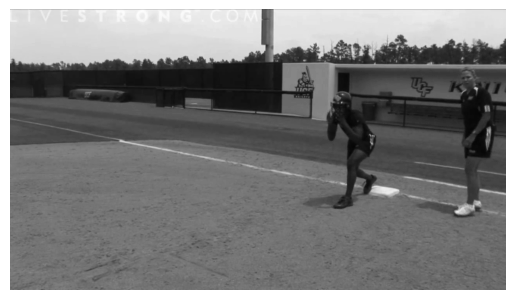

In [37]:
plt.imshow(io.imread("images/078273484.jpg", as_gray=True), cmap='gray')
plt.axis('off')
plt.show

In [ ]:
img = "078273484.jpg"
data = None
for data_pt in test_data:
    if data_pt['image'] == img:
        data = data_pt
y_est = trained_model.predict(X)

est_points = y_est.reshape((16, 2))
img, new_joints = crop_image(data)
padded = pad_image(img, np.max(img.shape), np.max(img.shape))
resized, _ = resize_image(padded, new_joints)
plt.imshow(resized, cmap='gray')
plt.scatter(est_points[:, 0], est_points[:, 1])
skeleton_lines(est_points, "yellow")
plt.axis('off')  # Turn off axis labels
plt.show()

179/179 [==============================] - 1s 5ms/step
026665619.jpg


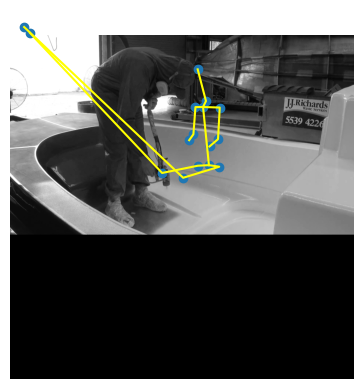

060829761.jpg


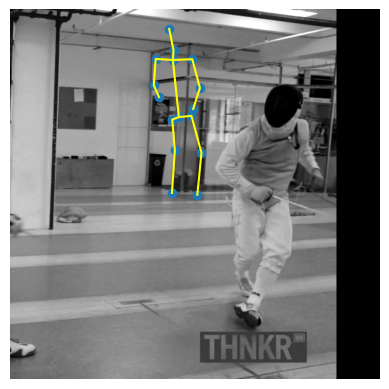

096894440.jpg


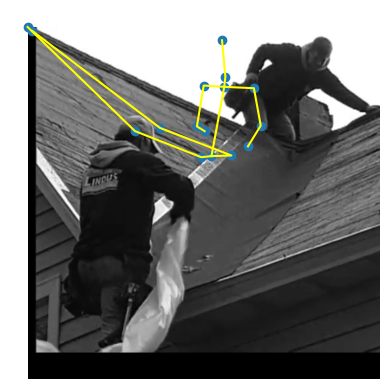

044287051.jpg


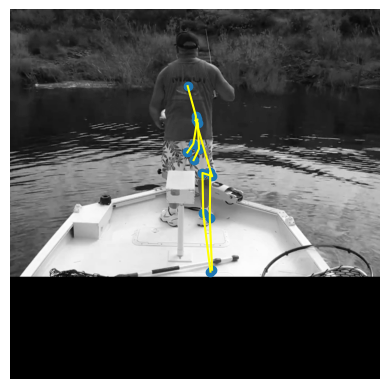

049966729.jpg


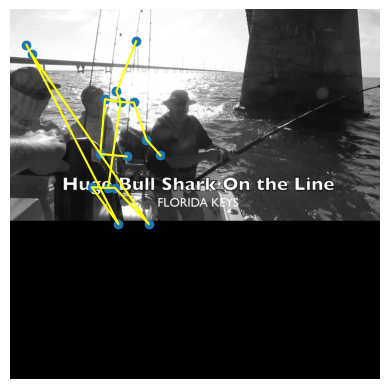

055022654.jpg


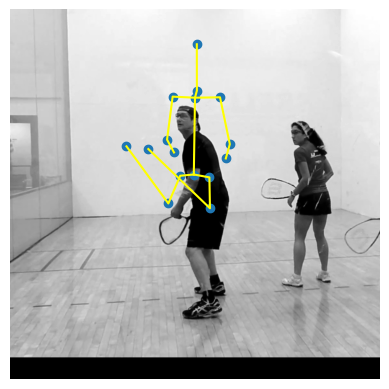

027420761.jpg


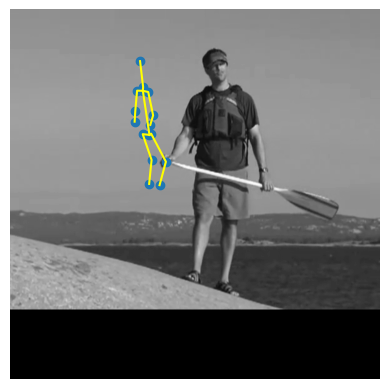

037158584.jpg


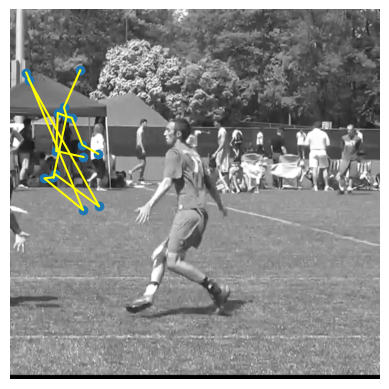

096731917.jpg


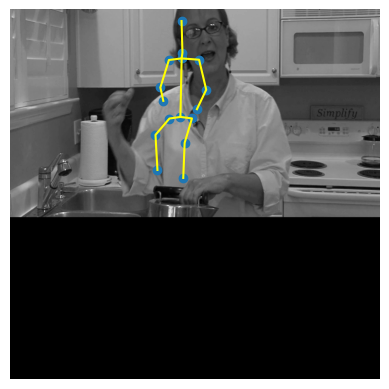

096435323.jpg


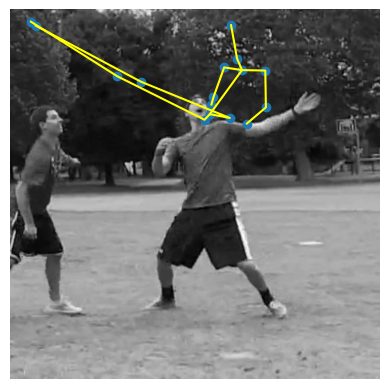

014465490.jpg


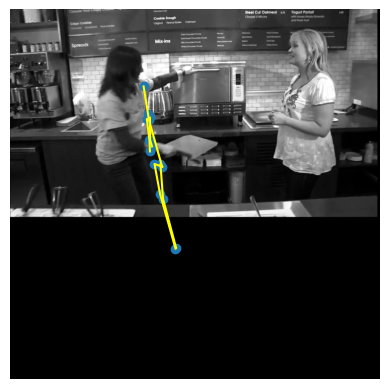

052187297.jpg


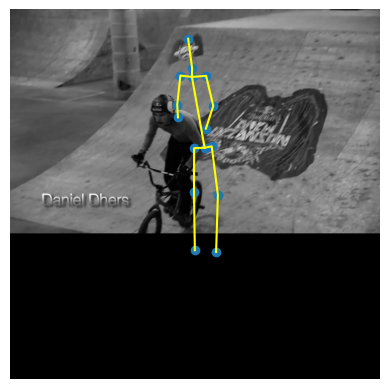

077339222.jpg


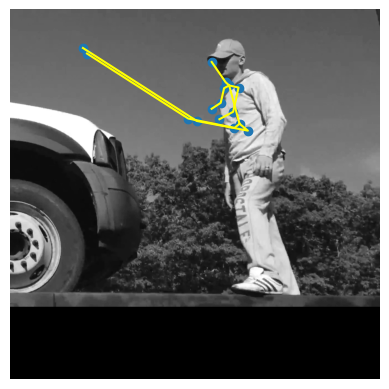

000024293.jpg


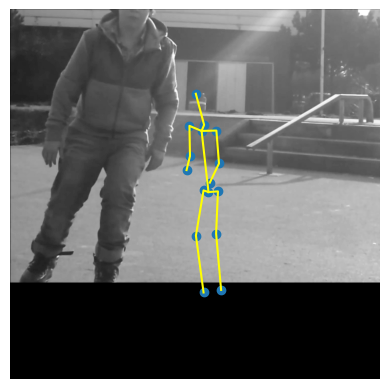

004187470.jpg


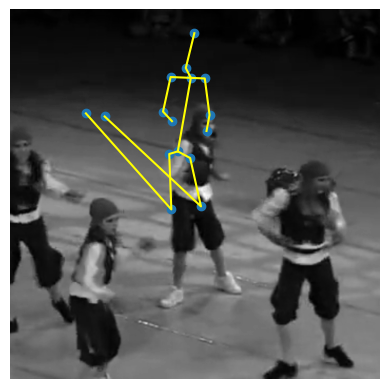

022309002.jpg


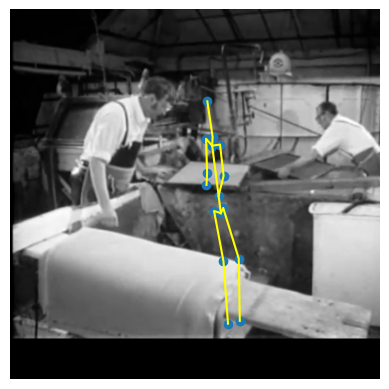

029445689.jpg


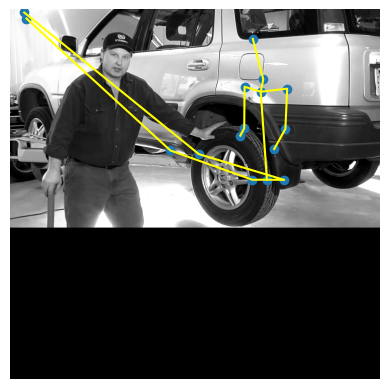

096568892.jpg


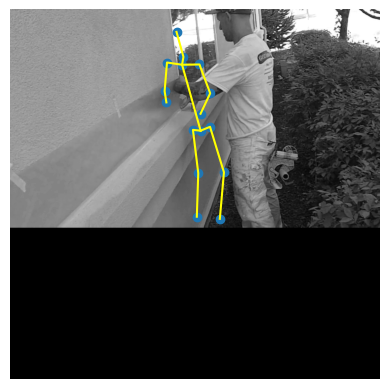

020459361.jpg


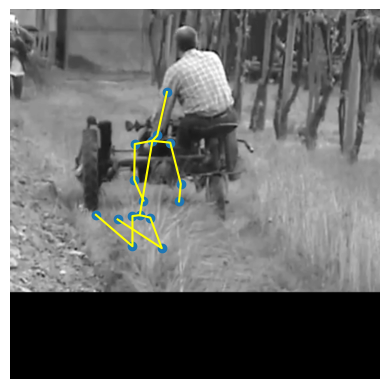

064280351.jpg


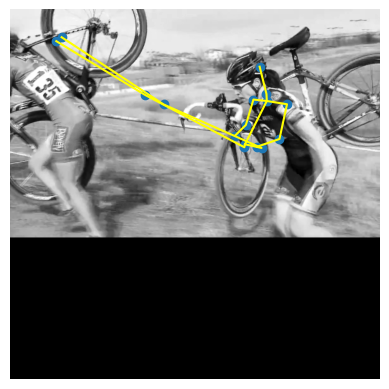

In [33]:
visualize_joint_predictions("test", num_visualize=20, random_visualize=False)